In [1]:
import pandas as pd
import numpy as np
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv',index_col='isic_id',low_memory=False)
df_test = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv',index_col='isic_id',low_memory=False)

In [3]:
groups = df['patient_id']
df = df.drop(['patient_id'],axis=1)
df_test  = df_test.drop(['patient_id'],axis=1)

In [4]:
def reduce_memory_usage(df, verbose=True):
    start_memory = df.memory_usage().sum() / 1024**2
    print("Memory usage of df is {:.2f} MB".format(start_memory))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:  # float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_memory = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_memory))
    print("Decreased memory percentage is: {:.2f}%".format(100 * (start_memory - end_memory) / start_memory))

    return df

reduce_memory_usage(df)
reduce_memory_usage(df_test)

Memory usage of df is 165.23 MB
Memory usage after optimization is: 79.94 MB
Decreased memory percentage is: 51.62%
Memory usage of df is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased memory percentage is: 59.59%


,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
isic_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0015657,45.0,male,posterior torso,2.699219,TBP tile: close-up,3D: XP,22.796875,20.00000,28.390625,27.046875,...,0.304932,1.281250,2.300781,0.479248,20,-155.1250,1511.0,114.000000,Memorial Sloan Kettering Cancer Center,CC-BY
ISIC_0015729,35.0,female,lower extremity,2.519531,TBP tile: close-up,3D: XP,16.656250,9.65625,31.312500,27.531250,...,0.000000,1.271484,2.011719,0.426270,25,-112.3750,629.5,-15.015625,"Frazer Institute, The University of Queensland...",CC-BY
ISIC_0015740,65.0,male,posterior torso,3.160156,TBP tile: close-up,3D: XP,24.250000,19.93750,30.468750,28.390625,...,0.230713,1.080078,2.705078,0.365967,110,-84.3125,1304.0,-28.578125,FNQH Cairns,CC-BY


In [5]:
initial_features = df.columns
useful_features = list(set(initial_features)&set(df_test.columns))
useful_features.append('target')
df = df.drop(list(set(initial_features)-set(useful_features)),axis=1)
# cat_col = [i for i in df.columns if (df[i].nunique()<=10)]
# object_columns = df.select_dtypes(include='object').columns.tolist()
# categorical_col = list(set(cat_col) |set(object_columns))
# categorical_col.remove('target')
categorical_col = df.select_dtypes(include='object').columns.tolist()
# df = df.dropna()
df =df.drop_duplicates()
categorical_col

['sex',
 'anatom_site_general',
 'image_type',
 'tbp_tile_type',
 'tbp_lv_location',
 'tbp_lv_location_simple',
 'attribution',
 'copyright_license']

In [6]:
from sklearn.metrics import roc_auc_score
def score(solution: np.ndarray, submission: np.ndarray, min_tpr: float=0.80) -> float:
    v_gt = abs(solution-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)   
    return(partial_auc)
def pauc_80(preds, data):
    score_value = score(data.get_label(), preds, min_tpr=0.8)
    return 'pauc_80', score_value, True

In [7]:
for i in categorical_col:
    df[i] = df[i].astype('category')
    df_test[i]=df_test[i].astype('category')
y = df['target']
X = df.drop(columns='target')

In [8]:
from lightgbm.callback import log_evaluation, early_stopping
from sklearn.model_selection import StratifiedGroupKFold
param = {'num_leaves': 101, 'learning_rate': 0.0954776317104028, 'feature_fraction': 0.8591600029583324, 'bagging_fraction': 0.8048542076895056, 'bagging_freq': 10, 'min_data_in_leaf': 91, 'lambda_l1': 6.4476981012330885, 'lambda_l2': 9.650137645071625}
param['objective'] = 'binary'
param['force_col_wise']= True
param['metric'] = 'none'
param['boosting_type'] = 'gbdt'
param['verbose'] = -1
# param['scale_pos_weight'] = (y == 0).sum() / (y== 1).sum()
# skf = StratifiedGroupKFold(n_splits=5)
skf = StratifiedKFold(n_splits=5)
acc = []
for train_index, test_index in skf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgb_data = lgb.Dataset(X_train,y_train,categorical_feature=categorical_col)
#     lgb_val = lgb.Dataset(X_test,y_test,categorical_feature=categorical_col, reference=lgb_data)

#         params['scale_pos_weight'] = (y_train == 0).sum() / (y_train == 1).sum()
    model = lgb.train(param,lgb_data,feval=pauc_80)
    y_pred = model.predict(X_test,num_iteration=model.best_iteration)
    acc.append(score(y_test,y_pred))
print(np.mean(acc))

0.15983164671196698


withoput group K Fold := 0.1598 , with group K fold := .1580

In [9]:
# from lightgbm.callback import log_evaluation, early_stopping
# # groups = df['patient_id']
# skf = StratifiedKFold(n_splits=5)
# def objective(trial):
#     params = {
#         'objective': 'binary',
#         'force_col_wise': True,
#         'metric':'none',
#         'boosting_type': 'gbdt',
#         'verbose':  -1,
#         'num_leaves': trial.suggest_int('num_leaves', 40, 200),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-10, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#     }
    

#     acc = []
#     for train_index, test_index in skf.split(X, y):
        
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y[train_index], y[test_index]
        
#         lgb_data = lgb.Dataset(X_train,y_train,categorical_feature=categorical_col)
# #     lgb_val = lgb.Dataset(X_test,y_test,categorical_feature=categorical_col, reference=lgb_data)
    
# #         params['scale_pos_weight'] = (y_train == 0).sum() / (y_train == 1).sum()
#         model = lgb.train(params,lgb_data,feval=pauc_80)
#         y_pred = model.predict(X_test,num_iteration=model.best_iteration)
#         acc.append(score(y_test,y_pred))
#     return np.mean(acc)

In [10]:
# %%time
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# print(f'Best pAUC: {study.best_trial.value:.2f}')
# print(f'Best parameters: {study.best_trial.params}')

In [11]:
param = {'num_leaves': 101, 'learning_rate': 0.0954776317104028, 'feature_fraction': 0.8591600029583324, 'bagging_fraction': 0.8048542076895056, 'bagging_freq': 10, 'min_data_in_leaf': 91, 'lambda_l1': 6.4476981012330885, 'lambda_l2': 9.650137645071625}
param['objective'] = 'binary'
param['force_col_wise']= True
param['metric'] = 'none'
param['boosting_type'] = 'gbdt'
param['verbose'] = -1
# param['scale_pos_weight'] = (y == 0).sum() / (y== 1).sum()

In [12]:
# X = df_train[feature_cols]
# y = df_train[target_col]
# groups = df_train[group_col]
# cv = StratifiedGroupKFold(10, shuffle=True, random_state=seed)

# def custom_metric(estimator, X, y_true):
#     y_hat = estimator.predict_proba(X)[:, 1]
#     min_tpr = 0.80
#     max_fpr = abs(1 - min_tpr)
    
#     v_gt = abs(y_true - 1)
#     v_pred = np.array([1.0 - x for x in y_hat])
    
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
#     return partial_auc

# val_score = cross_val_score(
#     estimator=estimator, 
#     X=X, y=y, 
#     cv=cv, 
#     groups=groups,
#     scoring=custom_metric,
# )

# print(f"scores are {val_score}")
# print(f"average of scores is {np.mean(val_score)}")

In [13]:
lgb_data = lgb.Dataset(X,y,categorical_feature=categorical_col)
final_model = lgb.train(
    {},
    lgb_data
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8264
[LightGBM] [Info] Number of data points in the train set: 401059, number of used features: 41
[LightGBM] [Info] Start training from score 0.000980


In [14]:
X_test = df_test

In [15]:
sub = pd.DataFrame({'target':final_model.predict(X_test)},index=df_test.index)
sub.to_csv('submission.csv')
!head submission.csv

isic_id,target
ISIC_0015657,5.501265067090138e-05
ISIC_0015729,4.107951590082628e-05
ISIC_0015740,0.00013210248001294879


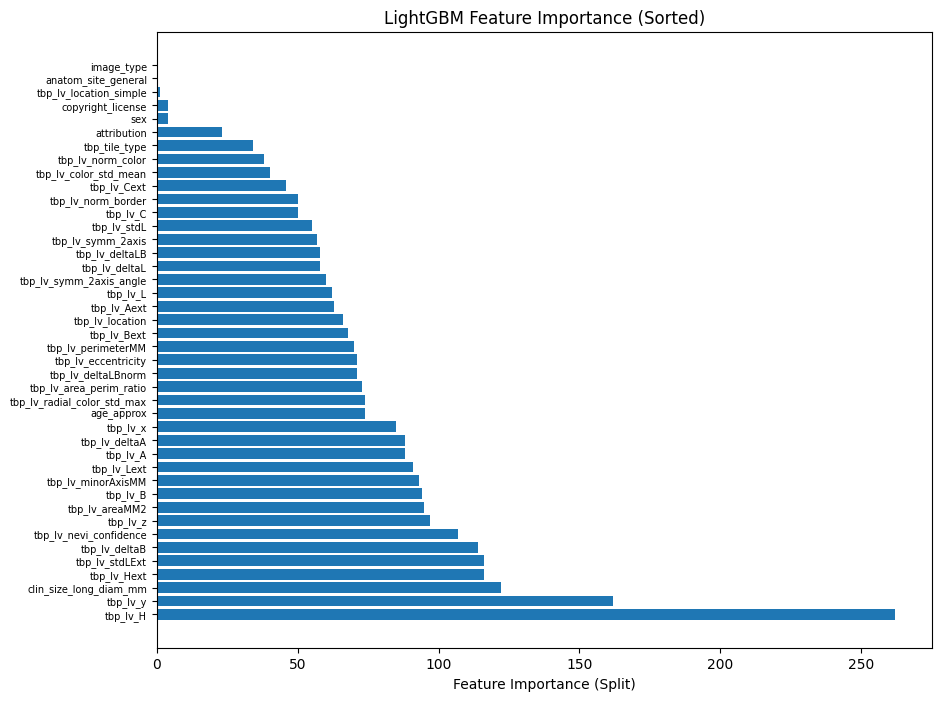

In [16]:
importance = final_model.feature_importance(importance_type='split')
feature_names = final_model.feature_name()

# Combine the feature names and their importance into a list of tuples
feature_importance = list(zip(feature_names, importance))

# Sort the list by importance in descending order
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Unzip the sorted tuples back into feature names and their corresponding importance
sorted_feature_names, sorted_importance = zip(*feature_importance)

import matplotlib.pyplot as plt

# Plotting sorted feature importance
plt.figure(figsize=(10, 8))  # Increased figure height for better spacing
plt.barh(sorted_feature_names, sorted_importance, align='center')

# Increase the spacing between the y-ticks
plt.gca().set_yticks(range(len(sorted_feature_names)))
plt.gca().set_yticklabels(sorted_feature_names, fontsize=7)  # Adjust fontsize for better readability

plt.xlabel("Feature Importance (Split)")
plt.title("LightGBM Feature Importance (Sorted)")
plt.show()

1. tbp_lv_H: 262
2. tbp_lv_y: 162
3. clin_size_long_diam_mm: 122
4. tbp_lv_Hext: 116
5. tbp_lv_stdLExt: 116
6. tbp_lv_deltaB: 114
7. tbp_lv_nevi_confidence: 107
8. tbp_lv_z: 97
9. tbp_lv_areaMM2: 95
10. tbp_lv_B: 94
11. tbp_lv_minorAxisMM: 93
12. tbp_lv_Lext: 91
13. tbp_lv_A: 88
14. tbp_lv_deltaA: 88


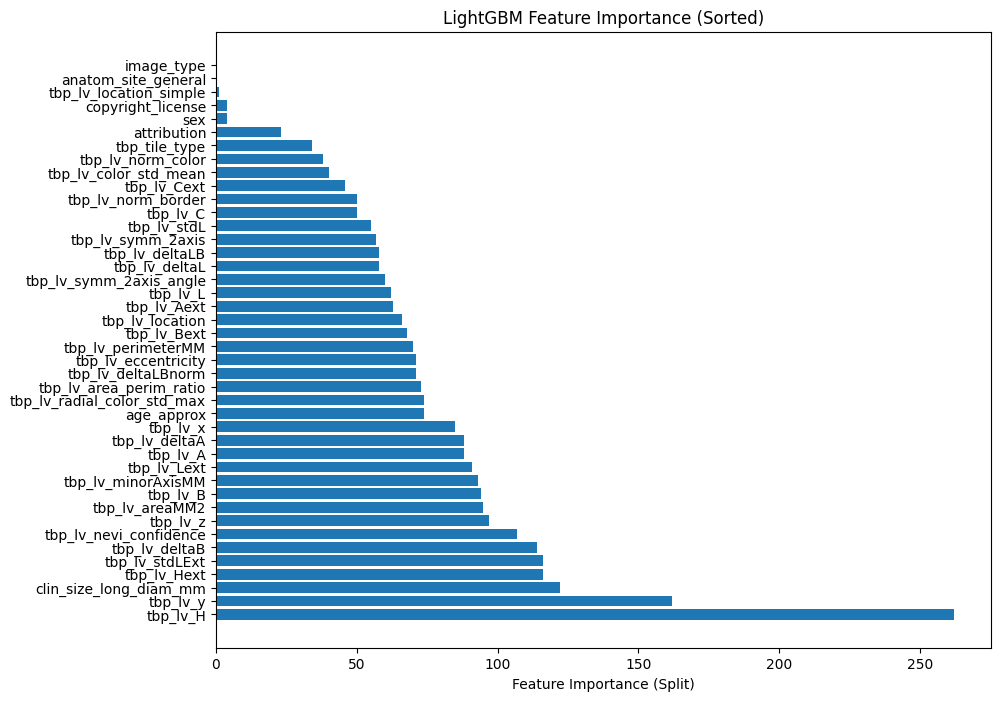

In [17]:
importance = final_model.feature_importance(importance_type='split')
feature_names = final_model.feature_name()

# Combine the feature names and their importance into a list of tuples
feature_importance = list(zip(feature_names, importance))

# Sort the list by importance in descending order
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Unzip the sorted tuples back into feature names and their corresponding importance
sorted_feature_names, sorted_importance = zip(*feature_importance)

# Extract the top 14 most important features
top_14_features = sorted_feature_names[:14]
top_14_importance = sorted_importance[:14]

# Display the top 14 most important features
for i, (feature, imp) in enumerate(zip(top_14_features, top_14_importance), 1):
    print(f"{i}. {feature}: {imp}")

# Plotting sorted feature importance (with all features for visualization)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))  # Increased figure height for better spacing
plt.barh(sorted_feature_names, sorted_importance, align='center')

# Increase the spacing between the y-ticks
plt.gca().set_yticks(range(len(sorted_feature_names)))
plt.gca().set_yticklabels(sorted_feature_names, fontsize=10)  # Adjust fontsize for better readability

plt.xlabel("Feature Importance (Split)")
plt.title("LightGBM Feature Importance (Sorted)")
plt.show()